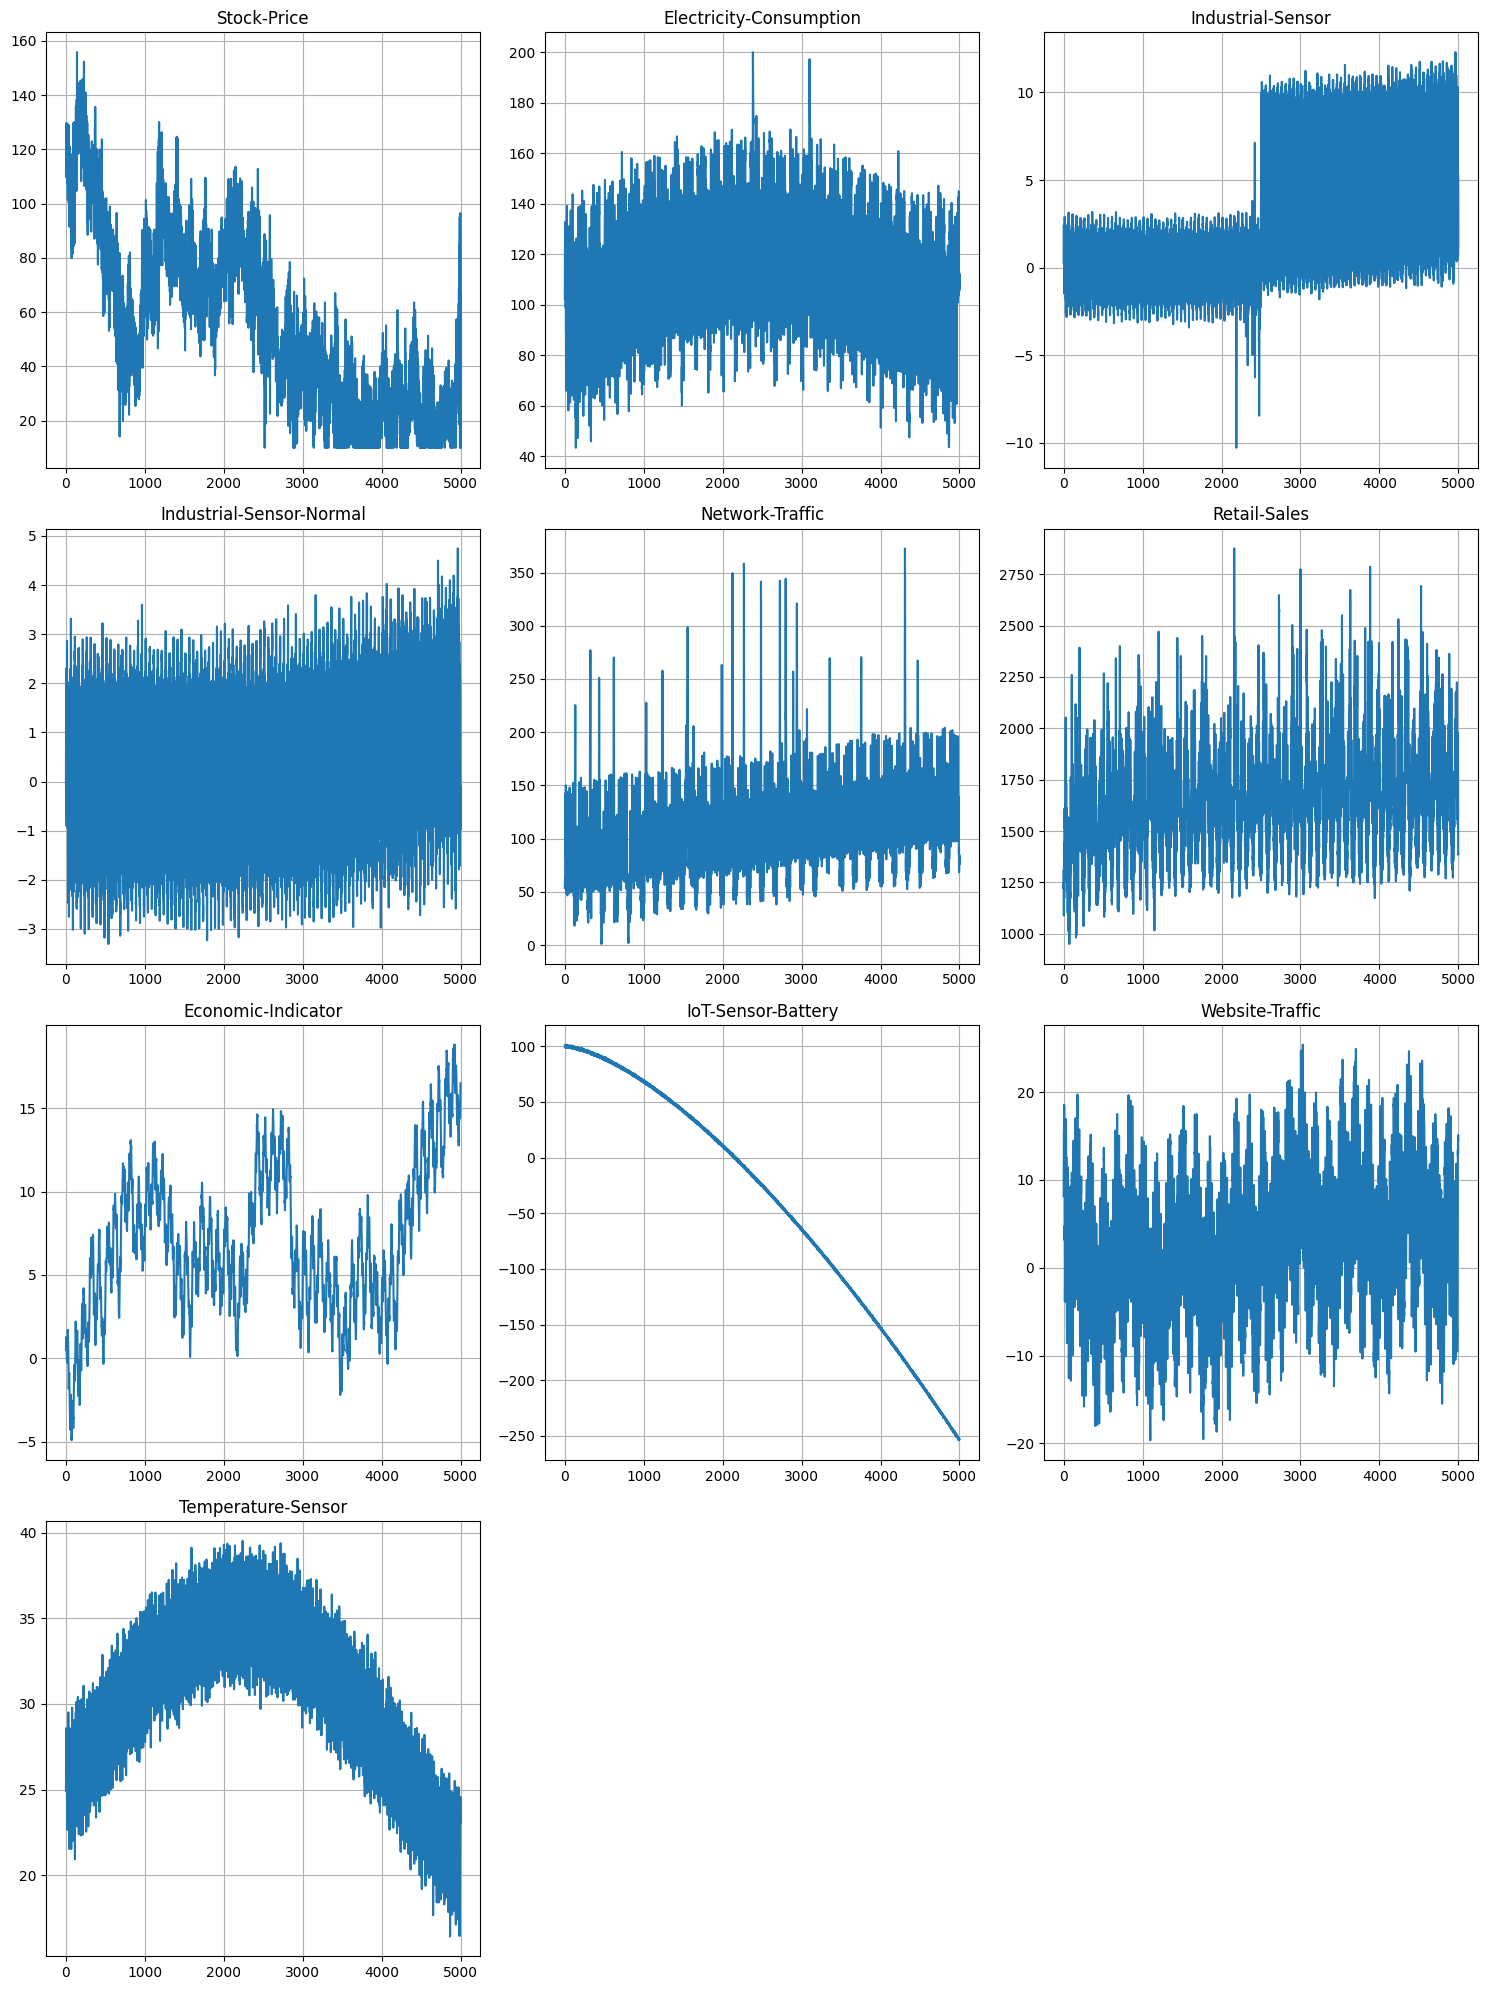

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd

def generate_stock_price(n=5000, volatility=0.3):
    """
    Generate realistic stock price time series with:
    - Long-term trend
    - Market cycles (medium frequency)
    - Seasonal patterns (high frequency)
    - Random walk component (market noise)
    - Occasional volatility clusters (GARCH-like behavior)
    
    Parameters:
    n (int): Length of the series
    volatility (float): Overall volatility factor
    
    Returns:
    numpy.ndarray: Simulated stock price series
    """
    # Start with initial price
    base_price = 100
    
    # Long-term trend (slow growth)
    trend = generate_exponential_signal(n, rate=0.00001, a=base_price)
    
    # Market cycles (medium frequency)
    market_cycle = 15 * generate_composite_sine(n, [
        (0.8, 0.001, 0),      # Long cycle (~3 years in daily data)
        (0.5, 0.005, 1.5),    # Medium cycle (~6 months)
    ])
    
    # Short-term seasonality (weekly pattern)
    seasonality = 3 * generate_sine_wave(n, amplitude=0.5, frequency=0.2)
    
    # Random walk component (efficient market hypothesis)
    noise = volatility * generate_random_walk(n)
    
    # Volatility clustering (market stress periods)
    garch_component, _ = generate_garch_signal(n, omega=0.1, alpha=0.15, beta=0.8)
    volatility_clusters = 8 * garch_component
    
    # Combine all components
    price = trend + market_cycle + seasonality + noise + volatility_clusters
    
    # Ensure price doesn't go negative
    return np.maximum(price, 0.1 * base_price)

def generate_electricity_consumption(n=5000, hourly_samples=24):
    """
    Generate electricity consumption pattern with:
    - Daily cycles (peak usage during day, low at night)
    - Weekly cycles (lower on weekends)
    - Seasonal component (higher in summer/winter)
    - Long-term growth trend
    - Random fluctuations
    - Occasional demand spikes
    
    Parameters:
    n (int): Length of the series
    hourly_samples (int): Number of samples per day
    
    Returns:
    numpy.ndarray: Simulated electricity consumption
    """
    # Base consumption level
    base_load = 100
    
    # Daily cycle (24-hour pattern)
    daily_pattern = generate_composite_sine(n, [
        (30, 1/hourly_samples, 0),                    # Main daily cycle
        (10, 2/hourly_samples, np.pi/6),              # Secondary cycle (morning/evening peaks)
    ])
    
    # Weekly pattern (lower on weekends)
    days = np.arange(n) // hourly_samples
    weekend_mask = np.zeros(n)
    weekend_mask[np.where((days % 7) >= 5)] = 1  # Weekend is day 5 and 6
    weekly_pattern = -15 * weekend_mask  # Lower consumption on weekends
    
    # Seasonal component (yearly)
    seasonal = 25 * generate_sine_wave(n, amplitude=1, frequency=1/(365*hourly_samples))
    
    # Long-term growth trend
    trend = generate_linear_signal(n, slope=0.002, intercept=base_load)
    
    # Random fluctuations
    noise = generate_white_noise(n, std=5)
    
    # Occasional demand spikes (hot days, events)
    num_spikes = n // (30*hourly_samples)  # Roughly monthly spikes
    spikes = np.zeros(n)
    spike_positions = np.random.choice(range(n), size=num_spikes, replace=False)
    for pos in spike_positions:
        width = np.random.randint(2, hourly_samples)
        height = np.random.uniform(20, 50)
        spikes[pos:pos+width] = height
    
    # Combine all components
    consumption = trend + daily_pattern + weekly_pattern + seasonal + noise + spikes
    
    return np.maximum(consumption, 0)  # Consumption cannot be negative

def generate_industrial_sensor(n=5000, failure_point=None):
    """
    Generate industrial sensor readings showing:
    - Baseline oscillation (normal equipment vibration)
    - Daily temperature cycle effects
    - Gradual degradation over time
    - Noise increasing with degradation
    - Anomalies preceding failure
    
    Parameters:
    n (int): Length of the series
    failure_point (int): Point of equipment failure (None for no failure)
    
    Returns:
    numpy.ndarray: Simulated sensor readings
    """
    if failure_point is None:
        failure_point = n + 1000  # No failure in this series
    
    # Basic sensor oscillation (normal operation)
    baseline = generate_composite_sine(n, [
        (2.0, 0.1, 0),          # Primary frequency
        (0.5, 0.3, 0.5),        # Secondary frequency
    ])
    
    # Daily temperature cycle effect
    daily_effect = generate_sine_wave(n, amplitude=1, frequency=0.02)
    
    # Gradual degradation (worsening with time)
    degradation = np.zeros(n)
    degradation_start = int(n/3)
    degradation[degradation_start:] = 0.5 * ((np.arange(n-degradation_start) / n)**2)
    
    # Increasing noise with degradation
    noise = np.random.normal(0, 0.2 + degradation, n)
    
    # Pre-failure anomalies
    anomalies = np.zeros(n)
    if failure_point < n:
        # Start showing warning signs at 80% of the way to failure
        warning_start = int(0.8 * failure_point)
        
        # Increasing frequency of anomalies as we approach failure
        for i in range(warning_start, min(failure_point, n)):
            # Probability of anomaly increases as we get closer to failure
            prob = 0.05 * (i - warning_start) / (failure_point - warning_start)
            if np.random.random() < prob:
                # Random spike or drop
                anomalies[i] = np.random.choice([-1, 1]) * np.random.uniform(3, 8)
        
        # Actual failure pattern if within series
        if failure_point < n:
            failure_pattern = generate_exp_sine_wave(n-failure_point, amplitude=3, frequency=0.3)
            anomalies[failure_point:] = failure_pattern
    
    # Combine all components
    sensor_reading = baseline + daily_effect + degradation * 5 + noise + anomalies
    
    return sensor_reading

def generate_network_traffic(n=5000, hourly_samples=24):
    """
    Generate network traffic time series with:
    - Diurnal pattern (business hours peak)
    - Weekly pattern (lower on weekends)
    - Gradual growth trend
    - Random bursts and traffic spikes
    - Occasional downtime
    
    Parameters:
    n (int): Length of the series
    hourly_samples (int): Number of samples per day
    
    Returns:
    numpy.ndarray: Simulated network traffic data
    """
    # Base traffic level
    base_traffic = 50
    
    # Daily pattern (working hours peak)
    hours = (np.arange(n) % hourly_samples) / hourly_samples * 24
    daily = np.zeros(n)
    
    # Working hours: 9-17
    working_mask = (9 <= hours) & (hours < 17)
    daily[working_mask] = 100 * np.sin((hours[working_mask] - 9) * np.pi / 8)**2
    
    # Evening hours: 17-23
    evening_mask = (17 <= hours) & (hours < 23)
    daily[evening_mask] = 40 * np.sin((hours[evening_mask] - 17) * np.pi / 6)**2
    
    # Night hours: remaining time set to 10
    night_mask = ~(working_mask | evening_mask)
    daily[night_mask] = 10
    
    # Weekly pattern
    days = np.arange(n) // hourly_samples
    weekly = np.zeros(n)
    weekly[np.where((days % 7) >= 5)] = -30  # Weekend reduction
    
    # Growth trend (increasing network usage)
    trend = generate_linear_signal(n, slope=0.01, intercept=base_traffic)
    
    # Random traffic bursts
    bursts = np.zeros(n)
    num_bursts = n // (7*hourly_samples)  # Weekly bursts on average
    burst_positions = np.random.choice(range(n), size=num_bursts, replace=False)
    
    for pos in burst_positions:
        width = np.random.randint(5, hourly_samples)
        height = np.random.uniform(50, 200)
        if pos + width < n:
            burst_shape = generate_gaussian_signal(width, a=1, sigma=width/5)
            burst_shape = burst_shape / np.max(burst_shape) * height
            bursts[pos:pos+width] += burst_shape
    
    # Occasional downtime (near zero traffic)
    downtime = np.ones(n)
    num_downtimes = max(1, n // (90*hourly_samples))  # Quarterly downtimes
    downtime_positions = np.random.choice(range(n), size=num_downtimes, replace=False)
    
    for pos in downtime_positions:
        width = np.random.randint(1, 8)  # 1-8 hours of downtime
        if pos + width < n:
            downtime[pos:pos+width] = 0.05  # 95% traffic reduction
    
    # Noise component
    noise = generate_white_noise(n, std=5)
    
    # Combine components
    traffic = (trend + daily + weekly + bursts + noise) * downtime
    
    return np.maximum(traffic, 0)  # Traffic cannot be negative

def generate_retail_sales(n=5000, days_per_sample=1):
    """
    Generate retail sales time series with:
    - Weekly pattern (weekend peaks)
    - Monthly pattern (peaks after paydays)
    - Quarterly pattern (seasonal merchandise)
    - Annual holiday pattern
    - Special events and promotions
    - Long-term trend
    
    Parameters:
    n (int): Length of the series
    days_per_sample (int): Number of days each sample represents
    
    Returns:
    numpy.ndarray: Simulated retail sales data
    """
    # Base sales level
    base_sales = 1000
    
    # Day/week pattern (weekend peaks)
    days = np.arange(n) * days_per_sample
    weekly_pattern = np.zeros(n)
    
    # Friday, Saturday, Sunday have higher sales
    day_of_week = days % 7
    weekly_pattern[day_of_week == 5] = 300  # Saturday
    weekly_pattern[day_of_week == 6] = 250  # Sunday
    weekly_pattern[day_of_week == 4] = 150  # Friday
    
    # Monthly pattern (peaks near paydays, typically 1st and 15th)
    monthly_pattern = np.zeros(n)
    day_of_month = days % 30
    
    # Higher sales after paydays
    monthly_pattern[(day_of_month < 3)] = 200     # 1st-3rd of month
    monthly_pattern[(14 <= day_of_month) & (day_of_month < 17)] = 150  # 15th-17th
    
    # Quarterly seasonal pattern
    quarterly = generate_sine_wave(n, amplitude=200, frequency=1/(90/days_per_sample))
    
    # Annual holiday pattern
    yearly_pattern = np.zeros(n)
    day_of_year = days % 365
    
    # Black Friday + Holiday shopping (Nov-Dec)
    black_friday_mask = (330 <= day_of_year) & (day_of_year < 360)
    yearly_pattern[black_friday_mask] = 500 * (1 - abs(day_of_year[black_friday_mask] - 345) / 15)
    
    # Back to school (August)
    school_mask = (213 <= day_of_year) & (day_of_year < 243)
    yearly_pattern[school_mask] = 200 * (1 - abs(day_of_year[school_mask] - 228) / 15)
    
    # Long-term growth trend (slightly superlinear)
    trend = generate_power_law_signal(n, a=base_sales, b=0.05)
    
    # Special promotions and events (random spikes)
    promotions = np.zeros(n)
    num_promotions = n // 60  # Roughly bimonthly
    promo_positions = np.random.choice(range(n), size=num_promotions, replace=False)
    
    for pos in promo_positions:
        width = np.random.randint(3, 7)  # 3-7 day promotions
        height = np.random.uniform(300, 700)
        if pos + width < n:
            promotions[pos:pos+width] = height
    
    # Random variations
    noise = generate_white_noise(n, std=50)
    
    # Combine all components
    sales = trend + weekly_pattern + monthly_pattern + quarterly + yearly_pattern + promotions + noise
    
    return np.maximum(sales, 0)  # Sales cannot be negative


# Base signal generation functions
def generate_linear_signal(n, slope=10, intercept=0):
    """Generate a linear signal with given slope and intercept"""
    x = np.arange(n)
    return slope * x + intercept

def generate_quadratic_signal(n, a=1, b=1, c=1):
    """Generate a quadratic signal: a*x^2 + b*x + c"""
    x = np.arange(n)
    return a * x ** 2 + b * x + c

def generate_exponential_signal(n, rate=0.01, a=1):
    """Generate an exponential signal: a*e^(rate*x)"""
    x = np.arange(n)
    return a*np.exp(rate * x) + 1

def generate_logarithmic_signal(n, base=2):
    """Generate a logarithmic signal with given base"""
    x = np.arange(1, n + 1)
    return np.log(x) / np.log(base)

def generate_logistic_signal(n, L=1, k=0.1, t0=None):
    """
    Generate a logistic (sigmoid) function signal representing S-shaped growth.
    
    Parameters:
    n (int): Length of the signal
    L (float): The curve's maximum value
    k (float): The growth rate or steepness of the curve
    t0 (float): The time of the sigmoid's midpoint (defaults to n/2)
    """
    if t0 is None:
        t0 = n / 2
        
    x = np.arange(n)
    return L / (1 + np.exp(-k * (x - t0)))

def generate_gompertz_signal(n, a=1, b=2, k=0.1):
    """
    Generate a Gompertz function signal, used in biology and economics.
    
    Parameters:
    n (int): Length of the signal
    a (float): The asymptotic value
    b (float): Displacement along the x-axis
    k (float): Growth rate
    """
    x = np.arange(n)
    return a * np.exp(-b * np.exp(-k * x))

def generate_power_law_signal(n, a=1, b=0.5):
    """
    Generate a power law signal for scaling relationships.
    
    Parameters:
    n (int): Length of the signal
    a (float): Scale parameter
    b (float): Power exponent
    """
    x = np.arange(1, n + 1)  # Avoid x=0 if b<0
    return a * x**b

def generate_step_signal(n, t0=None, c=0, d=1):
    """
    Generate a step function signal representing a sudden change.
    
    Parameters:
    n (int): Length of the signal
    t0 (int): Step transition point (defaults to n/2)
    c (float): Value before step
    d (float): Value after step
    """
    if t0 is None:
        t0 = n // 2
        
    signal = np.ones(n) * c
    signal[t0:] = d
    return signal

def generate_piecewise_linear_signal(n, breakpoints, values):
    """
    Generate a piecewise linear signal with specified values at breakpoints.
    
    Parameters:
    n (int): Length of the signal
    breakpoints (list): List of x-indices where values are specified
    values (list): List of y-values at the breakpoints
    """
    assert len(breakpoints) == len(values), "Number of breakpoints must equal number of values"
    
    # Add endpoints if not present
    if 0 not in breakpoints:
        breakpoints = [0] + list(breakpoints)
        values = [values[0]] + list(values)
    if n-1 not in breakpoints:
        breakpoints = list(breakpoints) + [n-1]
        values = list(values) + [values[-1]]
    
    # Sort by breakpoints
    bp_values = sorted(zip(breakpoints, values))
    sorted_bp = [bp for bp, _ in bp_values]
    sorted_values = [val for _, val in bp_values]
    
    # Create signal using linear interpolation
    signal = np.zeros(n)
    for i in range(len(sorted_bp) - 1):
        start_idx = sorted_bp[i]
        end_idx = sorted_bp[i + 1]
        start_val = sorted_values[i]
        end_val = sorted_values[i + 1]
        
        # Linear interpolation
        if end_idx > start_idx:
            indices = np.arange(start_idx, end_idx + 1)
            t = (indices - start_idx) / (end_idx - start_idx)
            signal[start_idx:end_idx+1] = (1 - t) * start_val + t * end_val
    
    return signal

def generate_gaussian_signal(n, a=1, t0=None, sigma=None):
    """
    Generate a Gaussian (bell curve) signal.
    
    Parameters:
    n (int): Length of the signal
    a (float): Peak amplitude
    t0 (float): Center position (defaults to n/2)
    sigma (float): Standard deviation (defaults to n/10)
    """
    if t0 is None:
        t0 = n / 2
    if sigma is None:
        sigma = n / 10
        
    x = np.arange(n)
    return a * np.exp(-((x - t0)**2) / (2 * sigma**2))

def generate_sine_wave(n, amplitude=1, frequency=0.5, phase=0):
    """Generate a sine wave with given amplitude, frequency and phase"""
    x = np.arange(n)
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

def generate_composite_sine(n, components):
    """
    Generate a signal composed of multiple sine waves.
    
    Parameters:
    n (int): Length of the signal
    components (list): List of tuples, each containing (amplitude, frequency, phase_shift, wave_type)
                      where wave_type is 'sin' or 'cos' (defaults to 'sin' if not specified)
    
    Returns:
    numpy.ndarray: The composite signal
    """
    x = np.arange(n)
    signal = np.zeros(n)
    
    for component in components:
        if len(component) == 3:
            amplitude, frequency, phase_shift = component
            wave_type = 'sin'
        elif len(component) == 4:
            amplitude, frequency, phase_shift, wave_type = component
        else:
            raise ValueError("Each component must be a tuple of (amplitude, frequency, phase_shift) or (amplitude, frequency, phase_shift, wave_type)")
        
        if wave_type.lower() == 'sin':
            signal += amplitude * np.sin(2 * np.pi * frequency * x + phase_shift)
        elif wave_type.lower() == 'cos':
            signal += amplitude * np.cos(2 * np.pi * frequency * x + phase_shift)
        else:
            raise ValueError("wave_type must be 'sin' or 'cos'")
            
    return signal

def generate_cosine_wave(n, amplitude=1, frequency=0.5, phase=0):
    """Generate a cosine wave with given amplitude, frequency and phase"""
    x = np.arange(n)
    return amplitude * np.cos(2 * np.pi * frequency * x + phase)

def generate_triangle_wave(n, amplitude=1, frequency=0.5):
    """Generate a triangle wave with given amplitude and frequency"""
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n), 0.5)

def generate_sawtooth_wave(n, amplitude=1, frequency=0.1, phase_shift=0.99):
    """
    Generate a sawtooth wave with consistent peak values.
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Peak amplitude of the wave
    frequency (float): Frequency of the wave
    phase_shift (float): Phase shift to align peaks with sample points (0-1)
    """
    # Phase shift ensures peaks align with discrete sample points
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n) + phase_shift * np.pi)

def generate_square_wave(n, amplitude=1, frequency=0.5):
    """Generate a square wave with given amplitude and frequency"""
    return amplitude * signal.square(2 * np.pi * frequency * np.arange(n))

def generate_sinc_wave(n, amplitude=1, frequency=1.0):
    """
    Generate a sinc wave (sin(x)/x)
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Amplitude of the wave
    frequency (float): Controls how quickly the sinc function decays (smaller = slower decay)
    """
    # Using a reasonable range for x to show the sinc function characteristics
    # Scale the range by frequency to control decay rate
    x = np.linspace(-8 * np.pi / frequency, 8 * np.pi / frequency, n)
    # Using numpy's sinc function (defined as sin(πx)/(πx))
    # Need to divide by π to get sin(x)/x
    return amplitude * np.sinc(x / np.pi)

def generate_exp_sine_wave(n, amplitude=1, frequency=0.5):
    """
    Generate an exponential sine wave (e^sin(x))
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Amplitude scaling factor
    frequency (float): Frequency of the sine component
    """
    x = np.arange(n)
    return amplitude * np.exp(np.sin(2 * np.pi * frequency * x))

def generate_autoregressive_signal(n, coeffs=[0.6, 0.2, 0.15], noise_std=1):
    """Generate an autoregressive signal with given coefficients and noise level"""
    ar_signal = np.zeros(n)
    p = len(coeffs)
    
    # Initialize with random values
    ar_signal[:p] = np.random.normal(0, noise_std, p)
    
    # Generate the AR process
    for i in range(p, n):
        ar_signal[i] = np.sum([coeffs[j] * ar_signal[i-j-1] for j in range(p)])
        ar_signal[i] += np.random.normal(0, noise_std)
    
    return ar_signal

def generate_arma_signal(n, ar_params, ma_params):
    """Generate an ARMA signal with given AR and MA parameters"""
    arma_process = ArmaProcess(ar=np.r_[1, -np.array(ar_params)], ma=np.r_[1, np.array(ma_params)])
    return arma_process.generate_sample(nsample=n)

def generate_random_walk(n, start=0):
    """Generate a random walk starting from the given value"""
    steps = np.random.normal(0, 1, n)
    return np.cumsum(steps) + start

def generate_white_noise(n, mean=0, std=1):
    """Generate white noise with given mean and standard deviation"""
    return np.random.normal(mean, std, n)

def generate_garch_signal(n=1000, omega=0.1, alpha=0.2, beta=0.7, seed=None):
    """
    Generate GARCH(1,1) time series data
    
    Parameters:
        n : Length of the series
        omega : Constant term (must be > 0)
        alpha : ARCH coefficient (must be >= 0)
        beta : GARCH coefficient (must be >= 0)
        seed : Random seed
    
    Returns:
        returns : The generated time series
        sigma2 : Conditional variance series
    """
    assert alpha + beta < 1, "α+β must be less than 1 for stationarity"
    assert omega > 0, "ω must be greater than 0"
    
    np.random.seed(seed)
    returns = np.zeros(n)
    sigma2 = np.zeros(n)
    
    # Initialize conditional variance
    sigma2[0] = omega / (1 - alpha - beta)
    
    # Generate GARCH process
    for t in range(1, n):
        returns[t] = np.random.normal(0, np.sqrt(sigma2[t-1]))
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    
    return returns, sigma2

# Noise and anomaly functions
def add_noise_by_snr(signal, snr_db=20):
    """Add Gaussian noise based on signal-to-noise ratio (SNR in dB)"""
    signal_power = np.var(signal)  # Signal power (variance)
    snr_linear = 10 ** (snr_db / 10)  # Convert dB to linear scale
    noise_variance = signal_power / snr_linear  # Noise variance = signal power / SNR
    noise = np.random.normal(0, np.sqrt(noise_variance), len(signal))
    return signal + noise

def add_poisson_noise(signal):
    """Add Poisson noise (requires non-negative signal)"""
    # Shift signal to non-negative if needed
    offset = np.min(signal)
    if offset < 0:
        signal_shifted = signal - offset
    else:
        signal_shifted = signal
    
    # Poisson noise variance equals mean, so no SNR calculation needed
    noisy_signal = np.random.poisson(np.maximum(signal_shifted, 0))  # Ensure non-negative
    
    # Restore original signal offset
    if offset < 0:
        noisy_signal = noisy_signal + offset
    return noisy_signal

def add_point_anomalies(signal, anomaly_ratio=0.05, base_amplitude_range=(0.1, 0.3)):
    """
    Add point anomalies, with amplitude adapted to the signal range
    
    Parameters:
    signal: Input signal
    anomaly_ratio: Proportion of anomalous points
    base_amplitude_range: Base anomaly amplitude range (adjusted based on signal range)
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in first 80% of data
    num_anomalies = int(train_length * anomaly_ratio)
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.2, base_amplitude_range[1] * 0.2)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    # Print debug info
    print(f"Signal range: {signal_range}")
    print(f"Adjusted anomaly amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    # Randomly select anomaly positions (only in first 80% of data)
    anomaly_positions = np.random.choice(train_length, num_anomalies, replace=False)
    
    # Generate anomalous signal
    anomalous_signal = signal.copy()
    for pos in anomaly_positions:
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos] += sign * amplitude
    
    return anomalous_signal

def add_pulse_anomalies(signal, num_pulses=3, pulse_width_range=(10, 30), base_amplitude_range=(0.1, 0.3)):
    """
    Add pulse anomalies, with amplitude adapted to the signal range
    
    Parameters:
    signal: Input signal
    num_pulses: Number of pulse anomalies to add
    pulse_width_range: Range of pulse widths (in sample points)
    base_amplitude_range: Base anomaly amplitude range (adjusted based on signal range)
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in first 80% of data
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.8, base_amplitude_range[1] * 0.8)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    # Print debug info
    print(f"Signal range: {signal_range}")
    print(f"Adjusted pulse amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    anomalous_signal = signal.copy()
    
    # Ensure pulses are spaced apart, but only in first 80% of data
    min_distance = max(pulse_width_range[1], train_length // (num_pulses * 2))
    
    # Generate non-overlapping pulse positions
    possible_positions = list(range(0, train_length - pulse_width_range[1]))
    pulse_positions = []
    for _ in range(num_pulses):
        while possible_positions:
            pos = np.random.choice(possible_positions)
            if not any(abs(pos - p) < min_distance for p in pulse_positions):
                pulse_positions.append(pos)
                possible_positions = [p for p in possible_positions 
                                   if abs(p - pos) >= min_distance]
                break
    
    # Add pulses
    for pos in pulse_positions:
        width = np.random.randint(pulse_width_range[0], pulse_width_range[1])
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos:pos+width] += sign * amplitude
    
    return anomalous_signal

# Utility functions for saving and plotting
def save_signal(signal, folder, signal_name, dataset_id=None, category=None, length=None):
    """
    Save signal to CSV file using a flat folder structure
    First column: timestamp, Second column: signal value
    
    Parameters:
    signal: Signal data
    folder: Base folder
    signal_name: Signal name
    dataset_id: Dataset ID
    category: Category (e.g., raw, SNR20dB)
    length: Signal length
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Build filename format
    filename = signal_name
    if dataset_id is not None:
        filename = f"dataset{dataset_id}_{filename}"
    if category is not None:
        filename = f"{filename}_{category}"
    if length is not None:
        filename = f"{filename}_length{length}"
    
    # Create timestamp column (simple sequence numbers)
    timestamps = np.arange(len(signal))
    
    # Save data as CSV file
    df = pd.DataFrame({
        'date': timestamps,
        'Feature1': signal
    })
    
    df.to_csv(os.path.join(folder, f"{filename}.csv"), index=False)

def plot_signals(signal_data_dict):
    """Visualize multiple signals in a grid layout"""
    num_signals = len(signal_data_dict)
    rows = (num_signals // 3) + (1 if num_signals % 3 > 0 else 0)
    
    plt.figure(figsize=(15, 5 * rows))
    for i, (name, signal) in enumerate(signal_data_dict.items()):
        plt.subplot(rows, 3, i + 1)
        plt.plot(signal)
        plt.title(name)
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main functions for dataset generation
def generate_and_save_datasets(seed, dataset_folder, dataset_id):
    """Generate and save a dataset with different time series types"""
    n = 5000  # Signal length
    np.random.seed(seed)  # Set random seed
    
    signal_generators = {
        # Complex composite time series
        "Stock-Price": lambda: generate_stock_price(n, volatility=0.8),  # Stock price simulation
        "Electricity-Consumption": lambda: generate_electricity_consumption(n, hourly_samples=24),  # Electricity consumption
        "Industrial-Sensor": lambda: generate_industrial_sensor(n, failure_point=2500),  # Industrial sensor with failure
        "Industrial-Sensor-Normal": lambda: generate_industrial_sensor(n),  # Normal industrial sensor
        "Network-Traffic": lambda: generate_network_traffic(n, hourly_samples=24),  # Network traffic patterns
        "Retail-Sales": lambda: generate_retail_sales(n, days_per_sample=1),  # Retail sales data
        
        # Mixed base signals for additional composite patterns
        "Economic-Indicator": lambda: generate_linear_signal(n, slope=0.005) + 
                                    generate_composite_sine(n, [(2, 0.01, 0), (1, 0.05, 0.5)]) + 
                                    0.2 * generate_random_walk(n),  # Economic indicator (trend+cycle+random)
        
        "IoT-Sensor-Battery": lambda: 100 - (generate_power_law_signal(n, a=0.001, b=1.5) + 
                                            5 * generate_sine_wave(n, amplitude=0.2, frequency=0.1) + 
                                            generate_white_noise(n, std=0.3)),  # IoT device battery level
        
        "Website-Traffic": lambda: generate_composite_sine(n, [
                                (10, 1/24, 0),               # Daily pattern
                                (5, 1/(24*7), np.pi/2),      # Weekly pattern
                                (3, 1/(24*30), np.pi/4)      # Monthly pattern
                                ]) + generate_step_signal(n, t0=n//2, c=0, d=5) + generate_white_noise(n, std=1.5),  # Website traffic with surge
        
        "Temperature-Sensor": lambda: 25 + 10 * generate_sine_wave(n, amplitude=1, frequency=1/(24*365)) + 
                                    3 * generate_sine_wave(n, amplitude=1, frequency=1/24) +
                                    generate_white_noise(n, std=0.8),  # Temperature sensor (yearly+daily cycle)
    }
    
    # 1. Generate raw dataset and save
    signal_data_dict = {}
    for signal_name, generator in signal_generators.items():
        signal_data = generator()
        signal_data_dict[signal_name] = signal_data
        save_signal(signal_data, dataset_folder, signal_name, dataset_id=dataset_id, category="raw", length=n)
    
    # Visualize raw signals
    plot_signals(signal_data_dict)

def generate_multiple_datasets(num_datasets=5):
    """Generate multiple datasets with different random seeds"""
    output_folder = "Dataset_generated_composite_univariate"  
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i in range(num_datasets):
        seed = i
        generate_and_save_datasets(seed, output_folder, i+1)

# Entry point
if __name__ == "__main__":
    generate_multiple_datasets(num_datasets=1)

Generating dataset 1, seed: 3430201122


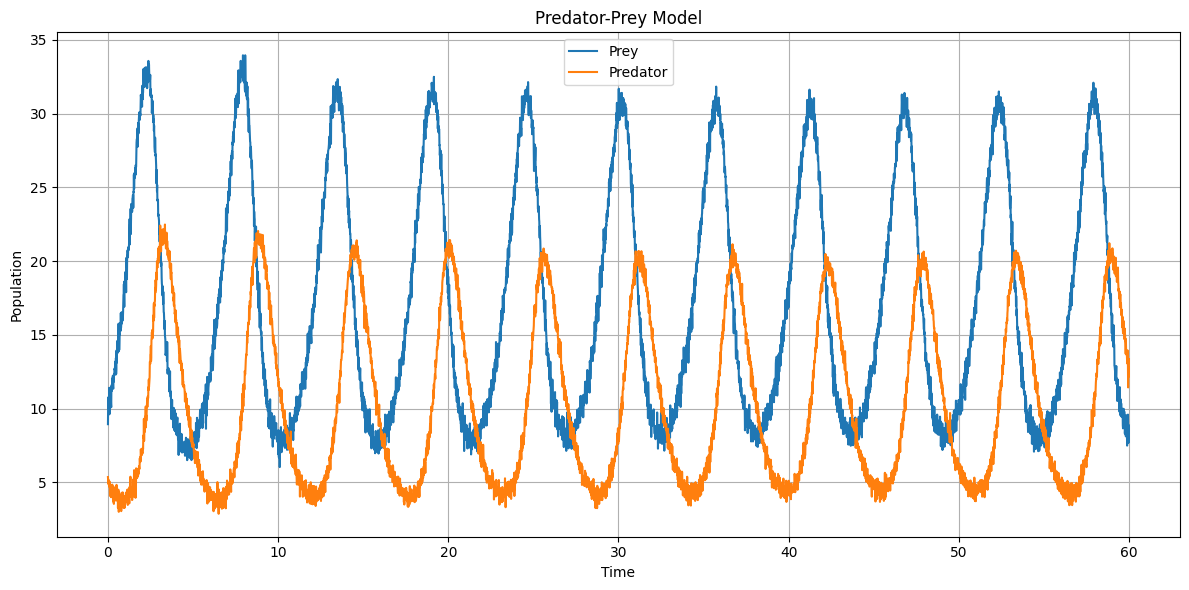

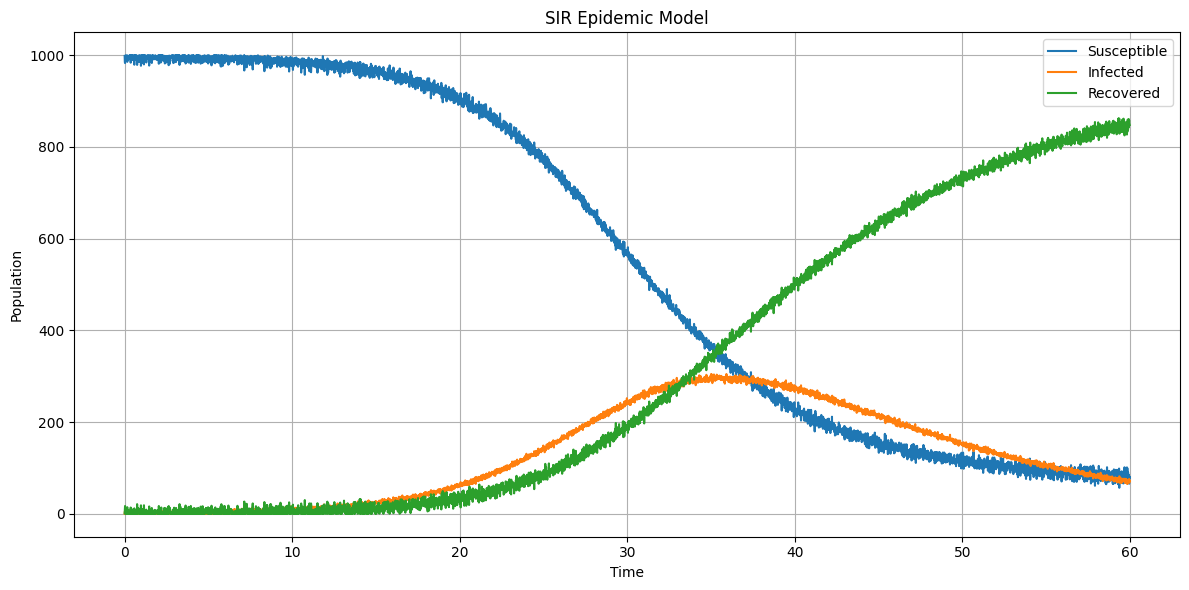

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    """
    Lotka-Volterra predator-prey model differential equations
    
    Parameters:
    t: time point
    z: state variables [prey population, predator population]
    alpha: growth rate of prey
    beta: predation rate
    delta: predator growth rate from consuming prey
    gamma: predator death rate
    """
    x, y = z  # z = [x(t), y(t)]
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

def sir_model(t, y, beta, gamma, N):
    """
    SIR epidemic model differential equations
    
    Parameters:
    t: time point
    y: state variables [susceptible, infected, recovered]
    beta: infection rate
    gamma: recovery rate
    N: total population
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def generate_lotka_volterra(n=5000, params=None, noise_level=0.02):
    """Generate Lotka-Volterra predator-prey time series data"""
    if params is None:
        params = {
            'alpha': 1.0,    # Prey growth rate
            'beta': 0.1,     # Predation rate
            'delta': 0.075,  # Predator growth rate from consuming prey
            'gamma': 1.5,    # Predator death rate
        }
    
    # Integration time range
    t_span = [0, 60]  # Changed from 100 to 60
    # Initial conditions [prey, predator]
    z0 = [10, 5]
    
    def lotka_volterra_ode(t, z):
        return lotka_volterra(t, z, params['alpha'], params['beta'], params['delta'], params['gamma'])
    
    # Solve the differential equation
    solution = solve_ivp(
        lotka_volterra_ode,
        t_span,
        z0,
        method='RK45',
        t_eval=np.linspace(t_span[0], t_span[1], n)
    )
    
    t = solution.t
    prey_pop = solution.y[0, :]
    predator_pop = solution.y[1, :]
    
    # Add noise
    prey_range = np.max(prey_pop) - np.min(prey_pop)
    predator_range = np.max(predator_pop) - np.min(predator_pop)
    
    prey_pop += np.random.normal(0, noise_level * prey_range, n)
    predator_pop += np.random.normal(0, noise_level * predator_range, n)
    
    # Ensure positive values
    prey_pop = np.maximum(prey_pop, 0.01)
    predator_pop = np.maximum(predator_pop, 0.01)
    
    return t, prey_pop, predator_pop

def generate_sir_model(n=5000, params=None, noise_level=0.01):
    """Generate SIR epidemic model time series data"""
    if params is None:
        params = {
            'beta': 0.3,    # Infection rate
            'gamma': 0.1,   # Recovery rate
            'N': 1000       # Total population
        }
    
    # Integration time range - CHANGED FROM 160 TO 60
    t_span = [0, 60]
    
    # Initial conditions [S, I, R]
    N = params['N']
    y0 = [N - 1, 1, 0]  # Start with 1 infected person
    
    def sir_ode(t, y):
        return sir_model(t, y, params['beta'], params['gamma'], params['N'])
    
    # Solve the differential equation
    solution = solve_ivp(
        sir_ode,
        t_span,
        y0,
        method='RK45',
        t_eval=np.linspace(t_span[0], t_span[1], n)
    )
    
    t = solution.t
    susceptible = solution.y[0, :]
    infected = solution.y[1, :]
    recovered = solution.y[2, :]
    
    # Add noise
    S_range = np.max(susceptible) - np.min(susceptible) + 1
    I_range = np.max(infected) - np.min(infected) + 1
    R_range = np.max(recovered) - np.min(recovered) + 1
    
    susceptible += np.random.normal(0, noise_level * S_range, n)
    infected += np.random.normal(0, noise_level * I_range, n)
    recovered += np.random.normal(0, noise_level * R_range, n)
    
    # Ensure positive values and total population remains N
    susceptible = np.maximum(susceptible, 0)
    infected = np.maximum(infected, 0)
    recovered = np.maximum(recovered, 0)
    
    total = susceptible + infected + recovered
    susceptible = susceptible / total * N
    infected = infected / total * N
    recovered = recovered / total * N
    
    return t, susceptible, infected, recovered

def save_multivariate_signal(signals, times, folder, signal_name, dataset_id=None, category=None, length=None):
    """Save multivariate signal to CSV file"""
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Build filename
    filename = signal_name
    if dataset_id is not None:
        filename = f"dataset{dataset_id}_{filename}"
    if category is not None:
        filename = f"{filename}_{category}"
    if length is not None:
        filename = f"{filename}_length{length}"
    
    # Create DataFrame with proper date range instead of numeric times
    n = len(times)
    data = {'date': pd.date_range(start='2020-01-01', periods=n)}  # Use date_range like in the third cell
    
    # Add signal data
    for i, (name, signal) in enumerate(signals.items(), 1):
        data[f'Feature{i}'] = signal
    
    df = pd.DataFrame(data)
    df.to_csv(os.path.join(folder, f"{filename}.csv"), index=False)

    
def plot_multivariate_signals(model_name, times, signals):
    """Plot multivariate time series data with English labels"""
    plt.figure(figsize=(12, 6))
    
    for name, data in signals.items():
        plt.plot(times, data, label=name)
    
    plt.title(f"{model_name} Model")
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def generate_system_timeseries(output_folder="Dataset_generated_composite_multivariate", num_datasets=1):
    """Generate multiple time series datasets from dynamic systems"""
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for dataset_id in range(1, num_datasets+1):
        # Set random seed for reproducibility
        seed = np.random.randint(0, 2**32)
        np.random.seed(seed)
        
        print(f"Generating dataset {dataset_id}, seed: {seed}")
        
        # 1. Generate Lotka-Volterra data
        n_lv = 5000
        
        # Introduce parameter variations between datasets
        lv_params = {
            'alpha': 1.0 + 0.2 * (np.random.random() - 0.5),
            'beta': 0.1 + 0.02 * (np.random.random() - 0.5),
            'delta': 0.075 + 0.015 * (np.random.random() - 0.5),
            'gamma': 1.5 + 0.3 * (np.random.random() - 0.5),
        }
        
        t_lv, prey, predator = generate_lotka_volterra(n=n_lv, params=lv_params, noise_level=0.02)
        
        # Plot Lotka-Volterra data
        plot_multivariate_signals("Predator-Prey", t_lv, {
            'Prey': prey,
            'Predator': predator
        })
        
        # Save Lotka-Volterra data
        save_multivariate_signal(
            {'Prey': prey, 'Predator': predator},
            t_lv,
            output_folder,
            'Lotka-Volterra',
            dataset_id=dataset_id,
            category='raw',
            length=n_lv
        )
        
        # 2. Generate SIR model data
        n_sir = 5000
        
        # Introduce parameter variations between datasets
        sir_params = {
            'beta': 0.3 + 0.06 * (np.random.random() - 0.5),
            'gamma': 0.1 + 0.02 * (np.random.random() - 0.5),
            'N': 1000
        }
        
        t_sir, susceptible, infected, recovered = generate_sir_model(n=n_sir, params=sir_params, noise_level=0.01)
        
        # Plot SIR data
        plot_multivariate_signals("SIR Epidemic", t_sir, {
            'Susceptible': susceptible,
            'Infected': infected,
            'Recovered': recovered
        })
        
        # Save SIR data
        save_multivariate_signal(
            {'Susceptible': susceptible, 'Infected': infected, 'Recovered': recovered},
            t_sir,
            output_folder,
            'SIR-Model',
            dataset_id=dataset_id,
            category='raw',
            length=n_sir
        )

# Run the generation
if __name__ == "__main__":
    generate_system_timeseries(num_datasets=1)

Generating weather-sales causal relationship data...
Generating ad-sales causal relationship data...
Generating macroeconomic causal relationship data...


Generating supply-demand-price causal relationship data...
Generating intervention effect causal relationship data...


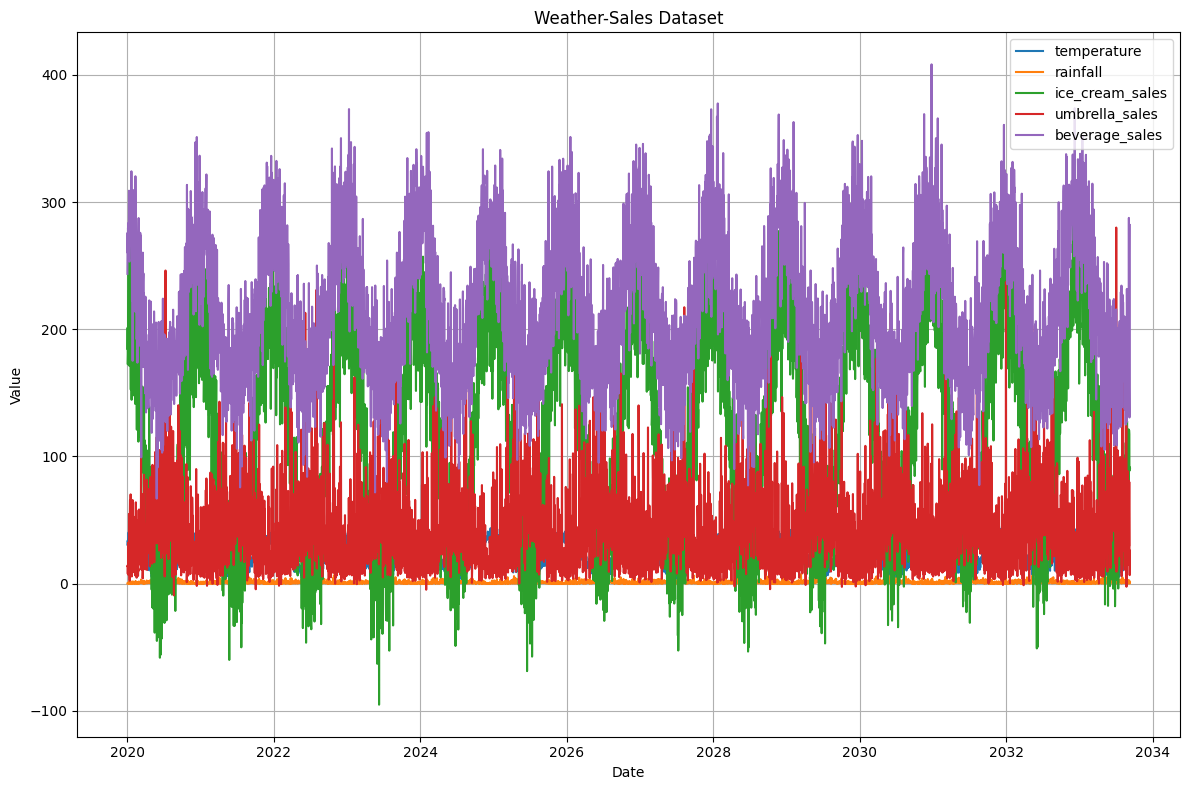

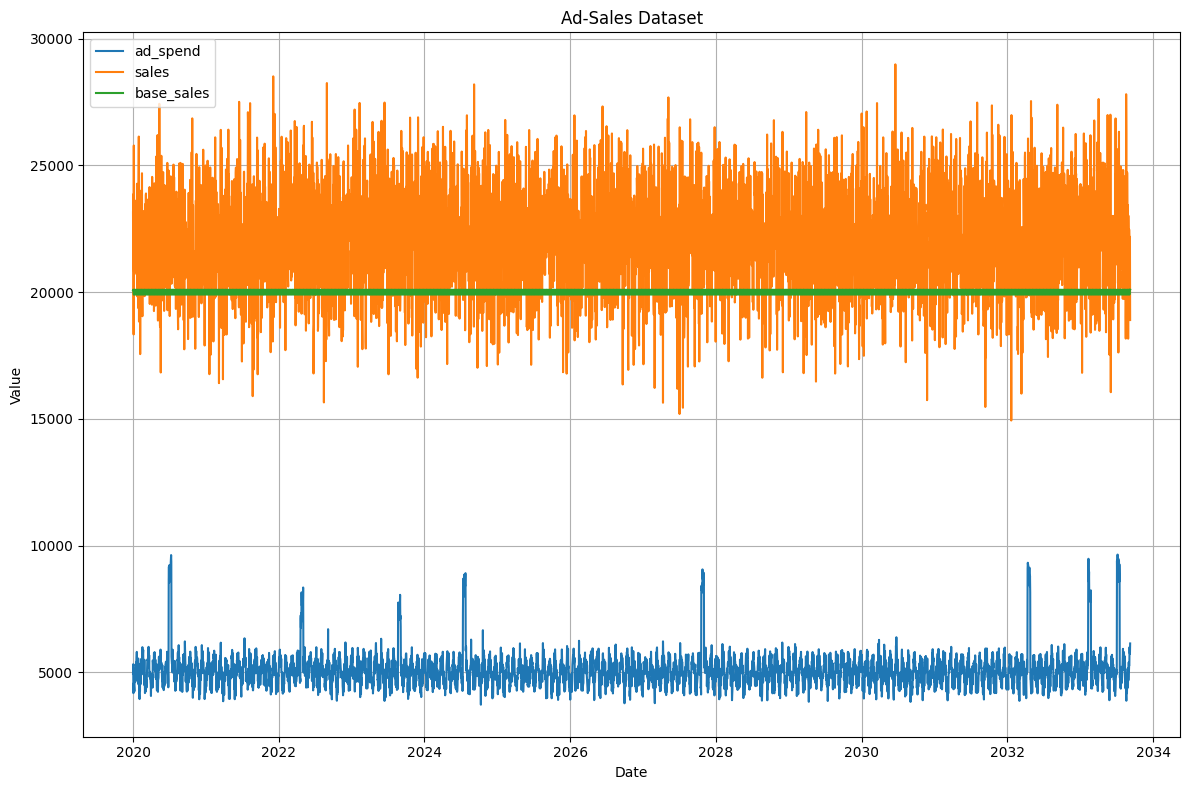

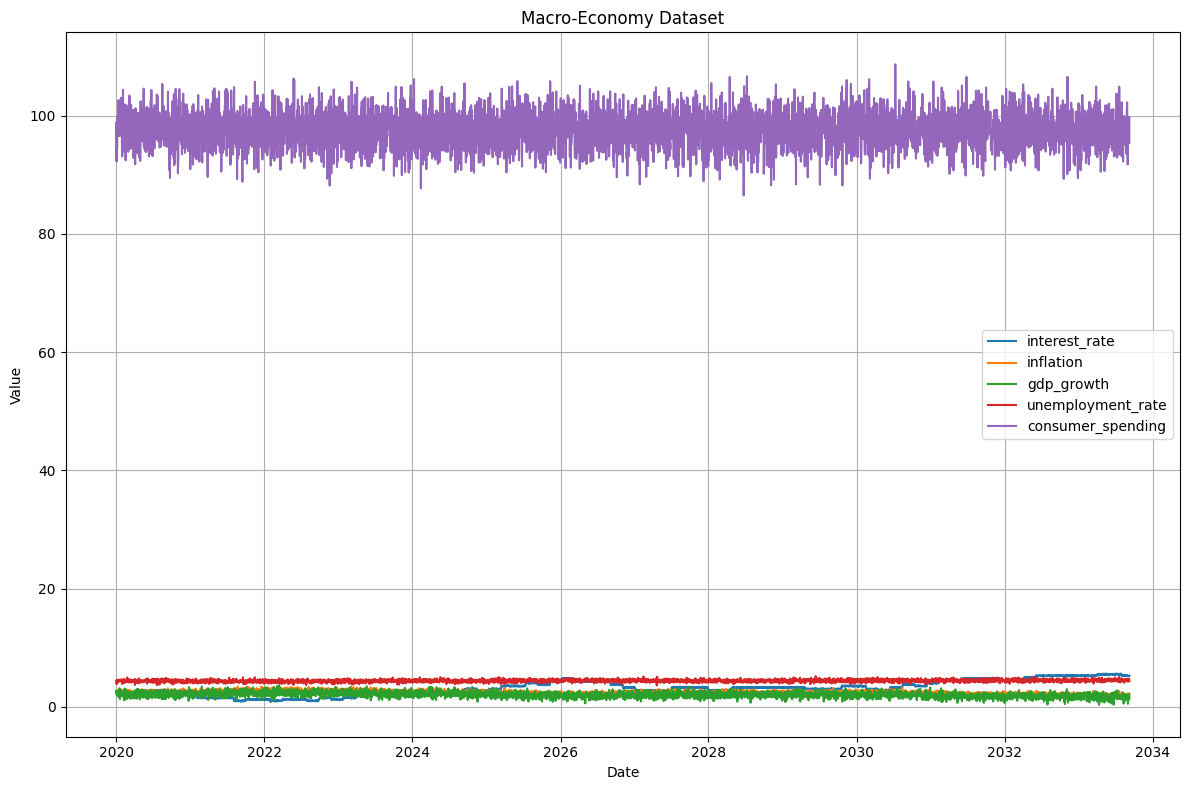

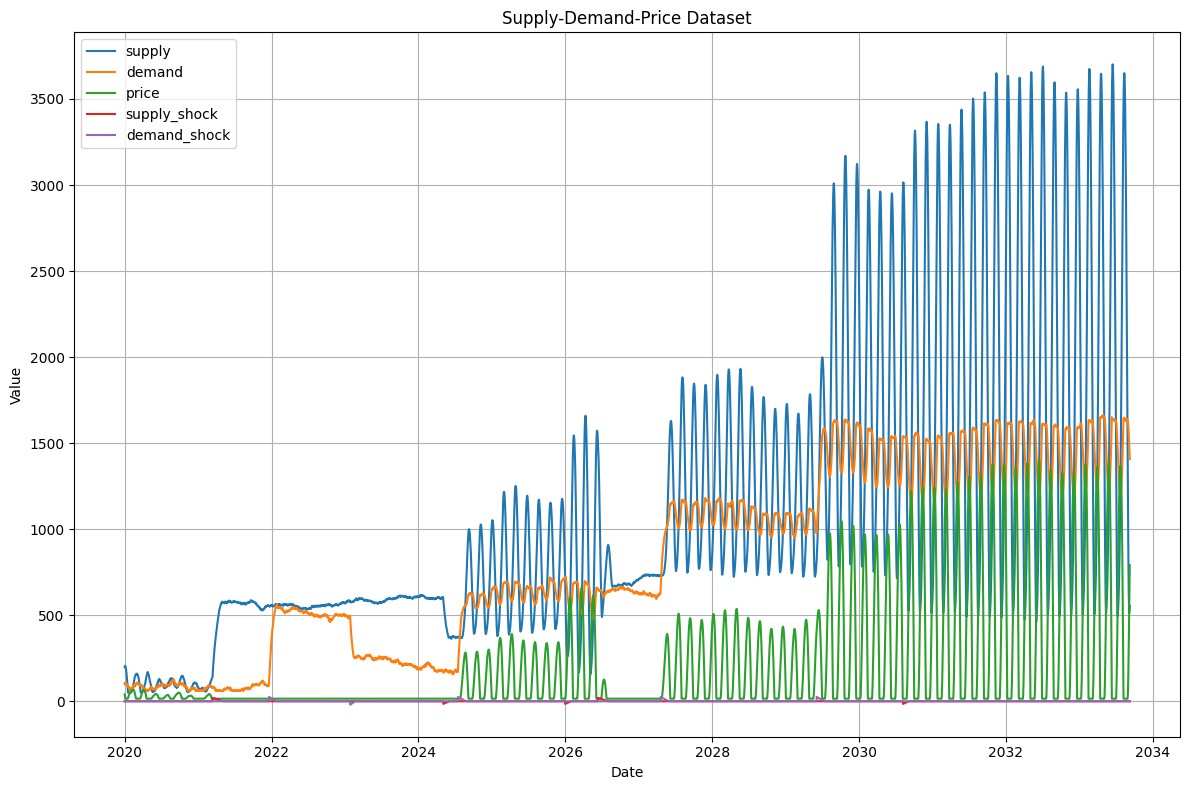

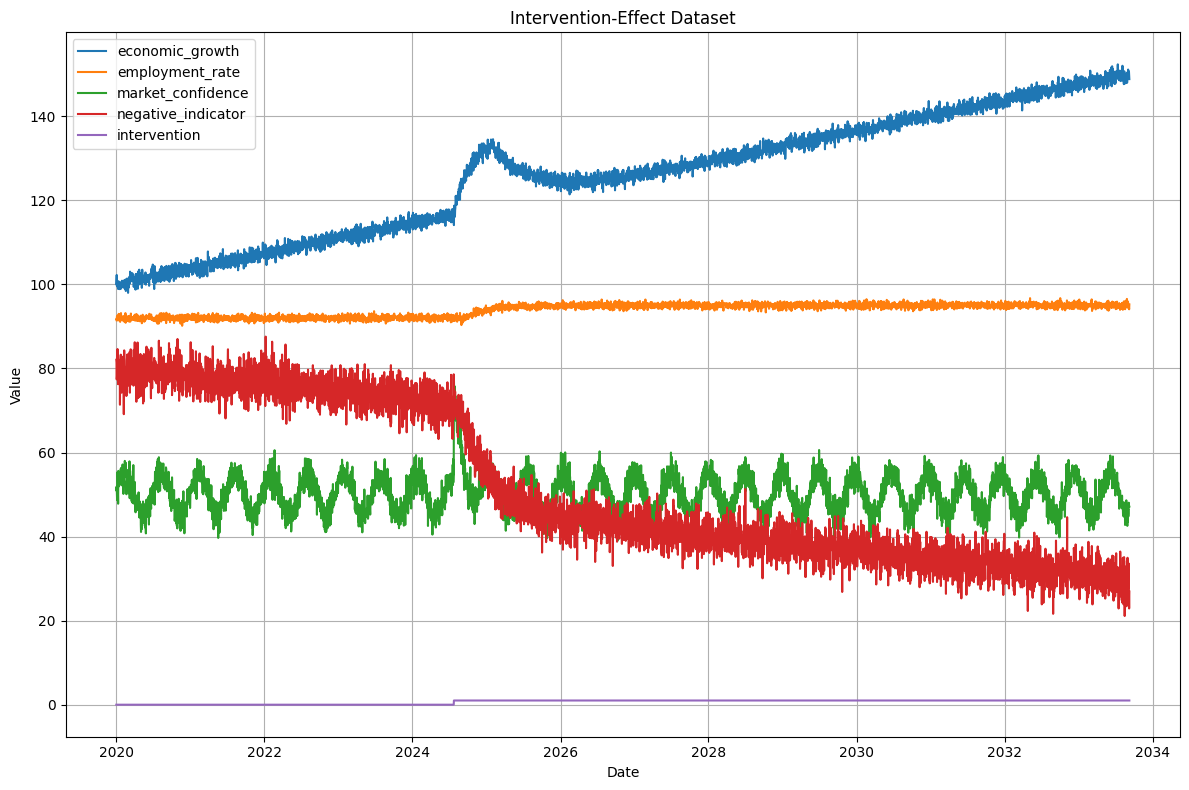

All causal time series data generation completed!


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns

def generate_causal_timeseries(n=1000, seed=None, dataset_id=1):
    """
    Generate multiple time series datasets with causal relationships
    
    Parameters:
        n: Number of data points
        seed: Random seed
        dataset_id: Dataset ID
    """
    if seed is not None:
        np.random.seed(seed)
        
    # Create output folder
    output_folder = "Dataset_generated_composite_multivariate"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Generate various causal time series
    weather_sales_df = generate_weather_sales_data(n, output_folder, dataset_id)
    ad_sales_df = generate_ad_sales_data(n, output_folder, dataset_id)
    macro_economy_df = generate_macro_economy_data(n, output_folder, dataset_id)
    supply_demand_df = generate_supply_demand_price_data(n, output_folder, dataset_id)
    intervention_df = generate_intervention_effect_data(n, output_folder, dataset_id)
    
    # Plot all datasets
    plot_dataset_features(weather_sales_df, "Weather-Sales Dataset")
    plot_dataset_features(ad_sales_df, "Ad-Sales Dataset")
    plot_dataset_features(macro_economy_df, "Macro-Economy Dataset")
    plot_dataset_features(supply_demand_df, "Supply-Demand-Price Dataset")
    plot_dataset_features(intervention_df, "Intervention-Effect Dataset")

def plot_dataset_features(df, title):
    """
    Plot all features of a dataset in a single figure
    
    Parameters:
        df: Dataframe containing the dataset
        title: Title of the plot
    """
    features = [col for col in df.columns if col != 'date']
    
    plt.figure(figsize=(12, 8))
    for feature in features:
        plt.plot(df['date'], df[feature], label=feature)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def save_causal_data(df, folder, signal_name, dataset_id=None, category='raw', length=None, exclude_columns=None):
    """
    Save causal data using consistent naming format and exclude specified columns
    
    Parameters:
        df: DataFrame
        folder: Output folder
        signal_name: Signal name
        dataset_id: Dataset ID
        category: Category
        length: Length
        exclude_columns: List of column names to exclude
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Build filename format consistent with second code block
    filename = signal_name
    if dataset_id is not None:
        filename = f"dataset{dataset_id}_{filename}"
    if category is not None:
        filename = f"{filename}_{category}"
    if length is not None:
        filename = f"{filename}_length{length}"
    
    # Create a copy of DataFrame and exclude specified columns
    if exclude_columns:
        df_to_save = df.drop(columns=exclude_columns)
    else:
        df_to_save = df
    
    # Save data
    df_to_save.to_csv(os.path.join(folder, f"{filename}.csv"), index=False)


def generate_weather_sales_data(n=1000, output_folder=".", dataset_id=None):
    """
    Generate weather and sales causal relationship data:
    - Temperature affects ice cream sales (positive correlation)
    - Rainfall affects umbrella sales (positive correlation)
    - Temperature slightly affects beverage sales (positive correlation)
    """
    print("Generating weather-sales causal relationship data...")
    
    # Use warmup period
    warmup = 100
    full_n = n + warmup
    
    # Generate temperature data with seasonality
    time = np.arange(full_n)
    season_component = 15 * np.sin(2 * np.pi * time / 365)  # Seasonal variation
    trend_component = 0.001 * time  # Slight global warming trend
    random_component = np.random.normal(0, 3, full_n)  # Random fluctuations
    temperature = 20 + season_component + trend_component + random_component
    
    # Generate rainfall data, partially influenced by temperature
    rain_base = np.random.exponential(1, full_n)
    rain_seasonal = -0.05 * season_component  # Seasonal influence (less rain in summer)
    rainfall = np.maximum(0, rain_base + rain_seasonal + np.random.normal(0, 0.5, full_n))
    
    # Generate sales data
    ice_cream_sales = 100 + 7 * (temperature - 20) + np.random.normal(0, 20, full_n)
    umbrella_sales = 10 + 30 * rainfall + np.random.normal(0, 5, full_n)
    beverage_sales = 200 + 3 * (temperature - 20) + 30 * (temperature > 30) + np.random.normal(0, 30, full_n)
    
    # Trim data after warmup period
    temperature = temperature[warmup:]
    rainfall = rainfall[warmup:]
    ice_cream_sales = ice_cream_sales[warmup:]
    umbrella_sales = umbrella_sales[warmup:]
    beverage_sales = beverage_sales[warmup:]
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.date_range(start='2020-01-01', periods=n),
        'temperature': temperature,
        'rainfall': rainfall,
        'ice_cream_sales': ice_cream_sales,
        'umbrella_sales': umbrella_sales,
        'beverage_sales': beverage_sales
    })
    
    # Save data using consistent naming format
    save_causal_data(df, output_folder, "Weather-Sales", dataset_id, "raw", n)
    
    return df

def generate_ad_sales_data(n=1000, output_folder=".", dataset_id=None):
    """
    Generate advertising expenditure and sales time series with lagged causal relationship:
    - Ad spending affects sales after 2-4 weeks (delay effect)
    - Market saturation effects are considered (diminishing returns)
    """
    print("Generating ad-sales causal relationship data...")
    
    # Add warmup period
    warmup = 50  # Effect kernel length is 21, so 50 is sufficient for warmup
    full_n = n + warmup
    
    # Basic time series
    time = np.arange(full_n)
    
    # Ad spending - including marketing campaigns
    base_ad_spend = 5000 + 500 * np.sin(2 * np.pi * time / 30)  # Base cyclical pattern
    campaigns = np.zeros(full_n)
    
    # Add marketing campaigns (only after warmup)
    campaign_points = np.random.choice(range(warmup + 20, full_n-50), 8, replace=False)
    for point in campaign_points:
        campaigns[point:point+14] += np.random.uniform(2000, 5000)
    
    ad_spend = base_ad_spend + campaigns + np.random.normal(0, 300, full_n)
    ad_spend = np.maximum(0, ad_spend)  # Ensure non-negative
    
    # Base sales
    base_sales = 20000 + 100 * np.sin(2 * np.pi * time / 7)  # Weekly cycle
    
    # Calculate lagged effect of advertising on sales
    ad_effect = np.zeros(full_n)
    
    # Create ad effect kernel - represents the distribution of ad effect over time
    effect_length = 21
    effect_kernel = np.zeros(effect_length)
    for i in range(effect_length):
        # Form an effect distribution starting from day 3, peaking around day 10, then gradually decreasing
        if i >= 3:
            effect_kernel[i] = norm.pdf(i, 10, 4) * 15
    
    # Apply advertising effect (convolution)
    for t in range(full_n):
        for lag in range(min(effect_length, t+1)):
            if t - lag >= 0:
                # Diminishing marginal returns on advertising
                marginal_effect = 2 * np.sqrt(ad_spend[t-lag]) 
                ad_effect[t] += effect_kernel[lag] * marginal_effect
    
    # Final sales = base sales + ad effect + noise
    sales = base_sales + ad_effect + np.random.normal(0, 2000, full_n)
    sales = np.maximum(0, sales)  # Ensure non-negative
    
    # Trim data after warmup period
    ad_spend = ad_spend[warmup:]
    sales = sales[warmup:]
    base_sales = base_sales[warmup:]
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.date_range(start='2020-01-01', periods=n),
        'ad_spend': ad_spend,
        'sales': sales,
        'base_sales': base_sales
    })
    
    # Save data - exclude base_sales column
    save_causal_data(df, output_folder, "Ad-Sales", dataset_id, "raw", n, exclude_columns=['base_sales'])
    
    return df

def generate_macro_economy_data(n=1000, output_folder=".", dataset_id=None):
    """
    Generate macroeconomic variables with causal relationships:
    - Interest rates affect inflation and GDP growth
    - Relationship between unemployment rate and GDP growth
    - Relationship between inflation and consumer spending
    """
    print("Generating macroeconomic causal relationship data...")
    
    # Use warmup period, generate longer sequence then trim
    warmup = 200  # Warmup period length
    full_n = n + warmup
    
    # Time
    time = np.arange(full_n)
    
    # Generate interest rate data (central bank controlled)
    base_rate = np.zeros(full_n)
    current_rate = 2.0  # Initial rate
    
    for t in range(full_n):
        # Possible rate change decision at intervals
        if t > 0 and t % 60 == 0:
            rate_change = np.random.choice([-0.5, -0.25, 0, 0.25, 0.5], p=[0.1, 0.2, 0.4, 0.2, 0.1])
            current_rate += rate_change
            current_rate = max(0.25, min(7, current_rate))  # Keep within reasonable range
        
        base_rate[t] = current_rate
    
    interest_rate = base_rate + np.random.normal(0, 0.05, full_n)
    
    # Inflation rate (affected by interest rate with lag)
    inflation_base = np.zeros(full_n)
    
    for t in range(full_n):
        if t < 90:  # Warmup period
            inflation_base[t] = 3.0  # Base inflation rate
        else:
            # Rising interest rates typically reduce inflation
            rate_effect = -0.2 * np.mean(interest_rate[t-90:t-30])
            inflation_base[t] = 3.0 + rate_effect
    
    inflation = inflation_base + 0.8 * np.random.normal(0, 0.3, full_n)
    inflation = np.maximum(0, inflation)  # Ensure non-negative
    
    # GDP growth rate (affected by interest rate with lag)
    gdp_growth_base = np.zeros(full_n)
    
    for t in range(full_n):
        if t < 60:  # Warmup period
            gdp_growth_base[t] = 2.5  # Base GDP growth rate
        else:
            # Rising interest rates typically reduce GDP growth
            rate_effect = -0.15 * np.mean(interest_rate[t-60:t])
            gdp_growth_base[t] = 2.5 + rate_effect
            
    gdp_growth = gdp_growth_base + np.random.normal(0, 0.4, full_n)
    
    # Unemployment rate (affected by GDP growth with lag)
    unemployment_base = np.zeros(full_n)
    
    for t in range(full_n):
        if t < 90:  # Warmup period
            unemployment_base[t] = 5.0  # Base unemployment rate
        else:
            # Higher GDP growth typically reduces unemployment
            gdp_effect = -0.3 * np.mean(gdp_growth[t-90:t-30])
            unemployment_base[t] = 5.0 + gdp_effect
            
    unemployment_rate = unemployment_base + np.random.normal(0, 0.2, full_n)
    unemployment_rate = np.maximum(2.0, unemployment_rate)  # Keep within reasonable range
    
    # Consumer spending index (affected by inflation and unemployment)
    consumer_spending = np.zeros(full_n)
    for t in range(full_n):
        # High inflation and unemployment typically reduce consumer spending
        inflation_effect = -0.3 * inflation[t]
        unemployment_effect = -0.4 * unemployment_rate[t]
        consumer_spending[t] = 100 + inflation_effect + unemployment_effect
        
    consumer_spending += np.random.normal(0, 3, full_n)
    
    # Trim data after warmup period
    interest_rate = interest_rate[warmup:]
    inflation = inflation[warmup:]
    gdp_growth = gdp_growth[warmup:]
    unemployment_rate = unemployment_rate[warmup:]
    consumer_spending = consumer_spending[warmup:]
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.date_range(start='2020-01-01', periods=n),
        'interest_rate': interest_rate,
        'inflation': inflation,
        'gdp_growth': gdp_growth,
        'unemployment_rate': unemployment_rate,
        'consumer_spending': consumer_spending
    })
    
    # Save data using consistent naming format
    save_causal_data(df, output_folder, "Macro-Economy", dataset_id, "raw", n)
    
    return df

def generate_supply_demand_price_data(n=1000, output_folder=".", dataset_id=None):
    """
    Generate supply, demand and price causal relationship data:
    - Increased supply leads to lower prices
    - Lower prices lead to increased demand
    - Increased demand eventually leads to price recovery
    """
    print("Generating supply-demand-price causal relationship data...")
    
    # Use warmup period
    warmup = 100
    full_n = n + warmup
    
    # Initialize time series
    supply = np.zeros(full_n)
    demand = np.zeros(full_n)
    price = np.zeros(full_n)
    
    # Set initial values
    supply[0] = 100
    demand[0] = 100
    price[0] = 80
    
    # External shocks
    supply_shocks = np.zeros(full_n)
    demand_shocks = np.zeros(full_n)
    
    # Add major supply shocks (after warmup)
    shock_points = np.random.choice(range(warmup + 50, full_n-100), 5, replace=False)
    for point in shock_points:
        if np.random.random() < 0.6:  # Positive shock
            supply_shocks[point:point+50] += np.linspace(20, 0, 50)
        else:  # Negative shock
            supply_shocks[point:point+30] -= np.linspace(15, 0, 30)
    
    # Add major demand shocks (after warmup)
    shock_points = np.random.choice(range(warmup + 50, full_n-100), 5, replace=False)
    for point in shock_points:
        if np.random.random() < 0.7:  # Positive shock
            demand_shocks[point:point+40] += np.linspace(25, 0, 40)
        else:  # Negative shock
            demand_shocks[point:point+25] -= np.linspace(20, 0, 25)
    
    # Dynamic system iteration - first run warmup to stabilize
    for t in range(1, full_n):
        # Supply affected by previous price
        if t <= 30:  # Simple model during early warmup
            supply[t] = supply[t-1] + supply_shocks[t]
        else:
            # Supply responds to price increases with delay
            price_effect_on_supply = 0.2 * (np.mean(price[t-30:t]) - price[t-30])
            supply[t] = supply[t-1] + price_effect_on_supply + supply_shocks[t]
        
        # Add random fluctuations
        supply[t] += np.random.normal(0, 2)
        supply[t] = max(supply[t], 50)  # Ensure supply doesn't get too low
        
        # Price affected by supply-demand balance
        market_pressure = 0.1 * (demand[t-1] - supply[t-1])
        price[t] = price[t-1] + market_pressure
        
        # Add random fluctuations
        price[t] += np.random.normal(0, 0.3)
        price[t] = max(price[t], 15)  # Ensure price doesn't get too low
        
        # Demand affected by price
        if t > 1:
            price_effect_on_demand = -0.3 * (price[t] - price[t-1])
            demand[t] = demand[t-1] + price_effect_on_demand + demand_shocks[t]
        else:
            demand[t] = demand[t-1] + demand_shocks[t]
        
        # Add random fluctuations
        demand[t] += np.random.normal(0, 3)
        demand[t] = max(demand[t], 60)  # Ensure demand doesn't get too low
    
    # Trim data after warmup period
    supply = supply[warmup:]
    demand = demand[warmup:]
    price = price[warmup:]
    supply_shocks = supply_shocks[warmup:]
    demand_shocks = demand_shocks[warmup:]
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.date_range(start='2020-01-01', periods=n),
        'supply': supply,
        'demand': demand,
        'price': price,
        'supply_shock': supply_shocks,
        'demand_shock': demand_shocks
    })
    
    # Save data - exclude shock columns
    save_causal_data(df, output_folder, "Supply-Demand-Price", dataset_id, "raw", n, 
                exclude_columns=['supply_shock', 'demand_shock'])
    
    return df

def generate_intervention_effect_data(n=1000, output_folder=".", dataset_id=None):
    """
    Generate intervention effect data:
    - Policy intervention effects on market, employment and other indicators
    - Before and after intervention comparison
    """
    print("Generating intervention effect causal relationship data...")
    
    # Time series
    time = np.arange(n)
    
    # Intervention time point
    intervention_time = n // 3
    
    # Generate different time series, each with different intervention responses
    
    # 1. Economic growth index - significant improvement after intervention
    growth_base = 100 + 0.01 * time + np.random.normal(0, 1, n)
    growth_effect = np.zeros(n)
    
    for t in range(intervention_time, n):
        time_since_intervention = t - intervention_time
        if time_since_intervention <= 180:  # Intervention effect gradually appears
            growth_effect[t] = 15 * (1 - np.exp(-0.015 * time_since_intervention))
        else:  # Intervention effect gradually decreases
            growth_effect[t] = 15 * np.exp(-0.005 * (time_since_intervention - 180))
    
    economic_growth = growth_base + growth_effect
    
    # 2. Employment rate - delayed response after intervention
    employment_base = 92 + np.random.normal(0, 0.5, n)
    employment_effect = np.zeros(n)
    
    for t in range(intervention_time, n):
        time_since_intervention = t - intervention_time
        if time_since_intervention >= 60:  # Takes effect after 60 days
            employment_effect[t] = 3 * (1 - np.exp(-0.01 * (time_since_intervention - 60)))
    
    employment_rate = employment_base + employment_effect
    
    # 3. Market confidence index - immediate boost after intervention, then regression
    confidence_base = 50 + 5 * np.sin(2 * np.pi * time / 180) + np.random.normal(0, 2, n)
    confidence_effect = np.zeros(n)
    
    for t in range(intervention_time, n):
        time_since_intervention = t - intervention_time
        # Immediate rise then fall
        confidence_effect[t] = 20 * np.exp(-0.02 * time_since_intervention)
    
    market_confidence = confidence_base + confidence_effect
    
    # 4. Negative indicator - intervention aims to reduce, but with lag
    negative_base = 80 - 0.005 * time + np.random.normal(0, 3, n)
    negative_effect = np.zeros(n)
    
    for t in range(intervention_time, n):
        time_since_intervention = t - intervention_time
        if time_since_intervention >= 30:  # Takes effect after 30 days
            negative_effect[t] = -25 * (1 - np.exp(-0.008 * (time_since_intervention - 30)))
    
    negative_indicator = negative_base + negative_effect
    negative_indicator = np.maximum(0, negative_indicator)  # Ensure non-negative
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.date_range(start='2020-01-01', periods=n),
        'economic_growth': economic_growth,
        'employment_rate': employment_rate,
        'market_confidence': market_confidence,
        'negative_indicator': negative_indicator
    })
    
    # Add intervention marker column
    df['intervention'] = 0
    df.loc[df['date'] >= pd.to_datetime('2020-01-01') + pd.Timedelta(days=intervention_time), 'intervention'] = 1
    
    # Save data - exclude intervention column
    save_causal_data(df, output_folder, "Intervention-Effect", dataset_id, "raw", n, exclude_columns=['intervention'])
    
    return df

if __name__ == "__main__":
    generate_causal_timeseries(n=5000, seed=42, dataset_id=1)
    print("All causal time series data generation completed!")